# SÁZKOVÁ KANCELÁŘ - SEGMENTACE ZÁKAZNÍKŮ - RFM ANALÝZA

## 1. import knihoven, datasetu a příprava dat pro standardizaci

In [1]:
#import knihoven
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn import datasets

In [2]:
#import datasetu a úprava datumu do použitelné podoby
df= pd.read_csv('rfm_tab_2.csv.gz',sep=",", compression='gzip', encoding='utf-8')

for column in df.columns:
    if df['RECENCY'].dtype == 'object':
        df['RECENCY'] = df['RECENCY'].astype(np.datetime64)

In [3]:
#vytvoření sloupce 'RECENCY_DATE' pro možnost dalšího výpočtu 'recency'
from datetime import datetime
def get_diff(): 
    dif=[]
    for date in df['RECENCY']:
        date_format = '%Y-%m-%d'
        current_date = date.to_pydatetime()  
        today = datetime.today()
        diff = today - current_date
        dif.append(diff.days) 
    return dif
df['RECENCY_DAYS'] = get_diff()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272986 entries, 0 to 272985
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ID_CLIENT       272986 non-null  int64         
 1   RECENCY         272986 non-null  datetime64[ns]
 2   FREQUENCY       272986 non-null  int64         
 3   MONETARY_VALUE  272986 non-null  int64         
 4   RECENCY_DAYS    272986 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 10.4 MB


In [5]:
df.to_csv('rfm_vstup_1.csv', index= False, encoding='utf8')

## 2. Standardizace datasetu pomocí Robust Scaling

In [6]:
data = df.loc[:,['ID_CLIENT','FREQUENCY','MONETARY_VALUE','RECENCY_DAYS']]
trans = RobustScaler()
data = trans.fit_transform(data)
df_scaled = pd.DataFrame(data, columns=['ID_CLIENT_sc','FREQUENCY_sc','MONETARY_sc','RECENCY_DAYS_sc'])
np.round(df_scaled.median(),1)

ID_CLIENT_sc       0.0
FREQUENCY_sc       0.0
MONETARY_sc        0.0
RECENCY_DAYS_sc    0.0
dtype: float64

## 3. Spojení původního datasetu a scaled hodnot

In [7]:
df = pd.concat([df, df_scaled], axis=1)

## 3. Zjištění optimálního počtu klastrů pomocí 'Elbow method'

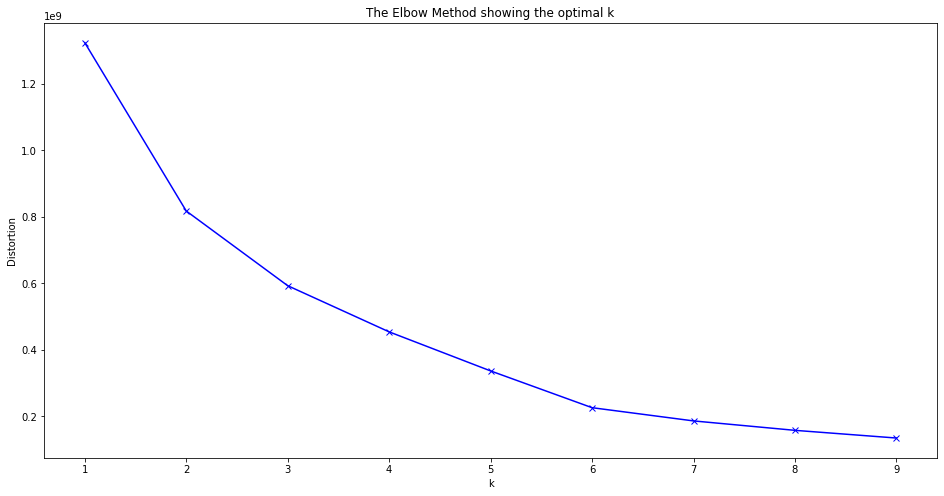

In [8]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Doporučený počet klastrů = 6

## 4. Použití KMeans na Recency - Frequency - Monetary_Value

In [39]:
#RECENCY
kmeans = KMeans(n_clusters=6)
kmeans.fit(df[['RECENCY_DAYS_sc']])
df['RECENCY_CLUSTER'] = kmeans.predict(df[['RECENCY_DAYS_sc']])

#funkce pro uspořádání dat v klastru
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df = order_cluster('RECENCY_CLUSTER', 'RECENCY_DAYS',df,False)

df.groupby('RECENCY_CLUSTER')['RECENCY_DAYS'].describe()

,count,mean,std,min,25%,50%,75%,max
RECENCY_CLUSTER,,,,,,,,
0,13206.0,1291.871952,79.715018,1161.0,1216.0,1299.0,1361.0,1426.0
1,50540.0,1030.976692,45.916150,937.0,1015.0,1021.0,1037.0,1160.0
2,22529.0,844.705491,49.011181,774.0,801.0,836.0,887.0,936.0
3,32201.0,702.851123,39.049979,636.0,669.0,702.0,735.0,773.0
4,40296.0,566.329462,40.494322,492.0,533.0,570.0,599.0,635.0
5,114214.0,415.174173,25.680431,394.0,396.0,402.0,428.0,491.0


In [40]:
#FREQUENCY
kmeans = KMeans(n_clusters=6)
kmeans.fit(df[['FREQUENCY_sc']])
df['FREQUENCY_CLUSTER'] = kmeans.predict(df[['FREQUENCY_sc']])

df = order_cluster('FREQUENCY_CLUSTER', 'FREQUENCY',df,True)

df.groupby('FREQUENCY_CLUSTER')['FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
FREQUENCY_CLUSTER,,,,,,,,
0,268510.0,155.902745,385.093158,1.0,3.00,21.0,113.0,3728.0
1,2687.0,7311.146632,3031.457398,3736.0,4717.50,6462.0,9443.0,14769.0
2,1003.0,22234.748754,5031.035893,14785.0,17822.50,21504.0,26104.0,32574.0
3,463.0,43167.440605,6900.132530,32834.0,37426.00,42222.0,48705.0,57616.0
4,255.0,72248.831373,10211.741895,58042.0,63650.00,70061.0,80038.5,97836.0
5,68.0,123725.279412,24376.460031,99209.0,106898.75,114608.5,132464.0,200615.0


In [41]:
#MONETARY_VALUE
kmeans = KMeans(n_clusters=6)
kmeans.fit(df[['MONETARY_sc']])
df['MONETARY_CLUSTER'] = kmeans.predict(df[['MONETARY_sc']])

df = order_cluster('MONETARY_CLUSTER', 'MONETARY_VALUE',df,True)

df.groupby('MONETARY_CLUSTER')['MONETARY_VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
MONETARY_CLUSTER,,,,,,,,
0,1.0,-1.519212e+09,NaN,-1.519212e+09,-1.519212e+09,-1.519212e+09,-1.519212e+09,-1.519212e+09
1,18.0,-2.579397e+08,1.388764e+08,-6.566652e+08,-3.344997e+08,-2.009244e+08,-1.643871e+08,-1.325857e+08
2,270939.0,1.936255e+05,1.343459e+06,-1.123777e+08,1.000000e+03,1.500000e+04,9.920000e+04,1.444140e+07
3,1708.0,2.866222e+07,1.191492e+07,1.444966e+07,1.870573e+07,2.512299e+07,3.598801e+07,6.106878e+07
4,316.0,9.362189e+07,3.720935e+07,6.126031e+07,6.929241e+07,8.244080e+07,1.041553e+08,3.327814e+08
5,4.0,6.680253e+08,1.917029e+08,4.535591e+08,5.956226e+08,6.492896e+08,7.216923e+08,9.199628e+08


In [12]:
print(df.tail(20))

        ID_CLIENT    RECENCY  FREQUENCY  MONETARY_VALUE  RECENCY_DAYS  \
272966     374066 2019-10-28       2290       642977091           395   
272967      82534 2019-10-27       1374      -145341484           396   
272968     174206 2019-10-23       2526      -273600479           400   
272969     176328 2019-09-06        523      -186595276           447   
272970     203035 2019-08-06       1461      -421753529           478   
272971     223704 2019-10-08       1297      -196712602           415   
272972     328261 2019-10-28        452      -132585701           395   
272973     126741 2017-02-19         46      -408912448          1376   
272974     301611 2018-09-23        329      -165811243           795   
272975     173884 2018-03-13        551      -181119102           989   
272976     508429 2019-06-19       4190      -396270709           526   
272977     160162 2019-10-27       4610      -656665161           396   
272978     409777 2019-10-14      14564      -16391

In [13]:
hodnota = df['RECENCY_CLUSTER']+3
print(hodnota)

0         7
1         7
2         7
3         7
4         7
         ..
272981    4
272982    8
272983    5
272984    8
272985    8
Name: RECENCY_CLUSTER, Length: 272986, dtype: int64


In [31]:
num_values = 6
def vaha_sloupec(nazev_sloupce):
    if nazev_sloupce =='RECENCY_CLUSTER':
        hodnota =  df['RECENCY_CLUSTER']+3
    elif nazev_sloupce == 'FREQUENCY_CLUSTER':
        hodnota = df['FREQUENCY_CLUSTER']
    elif nazev_sloupce =='MONETARY_CLUSTER':
        hodnota = df['MONETARY_CLUSTER']
    else:
        print('toto neznám')
    return hodnota

# def vaha_hodnota(hodnota):
#     if hodnota == 0:
#         hodnota = hodnota + 1
#     elif hodnota == 2:
#         hodnota = hodnota + 2
#     elif hodnota == 3:
#         hodnota = hodnota + 2
#     elif hodnota == 4:
#         hodnota = hodnota + 3
#     elif hodnota == 5:
#         hodnota = hodnota + 3
#     else:
#         print ('neznámá hodnota')
#     return hodnota




for nazev_sloupce in df.columns[9:12]:
    df[nazev_sloupce +'_weight'] = vaha_sloupec (nazev_sloupce)

print(df)  





        ID_CLIENT    RECENCY  FREQUENCY  MONETARY_VALUE  RECENCY_DAYS  \
0           72327 2019-05-25          2            2000           551   
1           72468 2019-04-13          8           -2134           593   
2           72619 2019-06-08         10           16000           537   
3           72358 2019-07-07          8            8000           508   
4           72408 2019-04-24          9           15000           582   
...           ...        ...        ...             ...           ...   
272981      97060 2017-09-22      22453      -133983327          1161   
272982     224233 2019-10-09      42005      -354799432           414   
272983      80221 2018-07-21      57413      -240863361           859   
272984     164204 2019-10-29     181811      -222643150           394   
272985     309005 2019-10-29      22144     -1519212475           394   

        ID_CLIENT_sc  FREQUENCY_sc   MONETARY_sc  RECENCY_DAYS_sc  \
0          -1.023993     -0.165289     -0.132755      

In [15]:
for i in range (0, num_values):
    if i==0:
        value=df[nazev_sloupce]+1
    else:
        i

## 5. Overall score

In [30]:
df['OVERALL_SCORE'] = df['RECENCY_CLUSTER'] + df['FREQUENCY_CLUSTER'] + df['MONETARY_CLUSTER']
df.groupby('OVERALL_SCORE')['RECENCY_DAYS','FREQUENCY','MONETARY_VALUE'].aggregate(['count', np.median, 'mean'])

c:\users\zuzan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


RECENCY_DAYS                     FREQUENCY            \
                     count median         mean     count    median   
OVERALL_SCORE                                                        
1                        1   1376  1376.000000         1      46.0   
2                    13001   1300  1293.221906     13001       8.0   
3                    50709   1021  1031.192668     50709       1.0   
4                    22987    832   842.700744     22987      13.0   
5                    32638    698   699.255622     32638      15.0   
6                    39468    567   563.922545     39468      19.0   
7                   110564    403   415.730853    110564      75.0   
8                     1936    395   425.573347      1936    6135.5   
9                      450    396   454.586667       450   15836.5   
10                     599    395   424.961603       599   23944.0   
11                     319    395   419.780564       319   42342.0   
12                     112    395   439.508929       112   63267.5   
13                     149    394   406.697987       149   75453.0   
14                      53    394   398.622642        53  115177.0   

                             MONETARY_VALUE                             
                        mean          count       median          mean  
OVERALL_SCORE                                                           
1                  46.000000              1 -408912448.0 -4.089124e+08  
2                  48.562188          13001       9000.0  2.009051e+04  
3                  39.890414          50709       1000.0  4.161347e+04  
4                 132.837473          22987      11000.0  1.270976e+05  
5                 131.436087          32638      13000.0  1.306070e+05  
6                 186.716352          39468      14004.0  1.276302e+05  
7                 313.980364         110564      49600.0  2.655488e+05  
8                7925.565083           1936    6173554.5  8.464005e+06  
9               17506.960000            450   17490295.0  2.535779e+07  
10              25899.380634            599   24392891.0  2.878085e+07  
11              45025.172414            319   39593613.0  4.060422e+07  
12              65545.392857            112   61015297.5  6.442433e+07  
13              77111.583893            149   77583534.0  8.270332e+07  
14             124904.773585             53  115872669.0  1.214694e+08

In [32]:
df['OVERALL_SCORE_weight'] = df['RECENCY_CLUSTER_weight'] + df['FREQUENCY_CLUSTER_weight'] + df['MONETARY_CLUSTER_weight']
df.groupby('OVERALL_SCORE_weight')['RECENCY_DAYS','FREQUENCY','MONETARY_VALUE'].aggregate(['count', np.median, 'mean'])

c:\users\zuzan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


RECENCY_DAYS                     FREQUENCY            \
                            count median         mean     count    median   
OVERALL_SCORE_weight                                                        
4                               1   1376  1376.000000         1      46.0   
5                           13001   1300  1293.221906     13001       8.0   
6                           50709   1021  1031.192668     50709       1.0   
7                           22987    832   842.700744     22987      13.0   
8                           32638    698   699.255622     32638      15.0   
9                           39468    567   563.922545     39468      19.0   
10                         110564    403   415.730853    110564      75.0   
11                           1936    395   425.573347      1936    6135.5   
12                            450    396   454.586667       450   15836.5   
13                            599    395   424.961603       599   23944.0   
14                            319    395   419.780564       319   42342.0   
15                            112    395   439.508929       112   63267.5   
16                            149    394   406.697987       149   75453.0   
17                             53    394   398.622642        53  115177.0   

                                    MONETARY_VALUE                             
                               mean          count       median          mean  
OVERALL_SCORE_weight                                                           
4                         46.000000              1 -408912448.0 -4.089124e+08  
5                         48.562188          13001       9000.0  2.009051e+04  
6                         39.890414          50709       1000.0  4.161347e+04  
7                        132.837473          22987      11000.0  1.270976e+05  
8                        131.436087          32638      13000.0  1.306070e+05  
9                        186.716352          39468      14004.0  1.276302e+05  
10                       313.980364         110564      49600.0  2.655488e+05  
11                      7925.565083           1936    6173554.5  8.464005e+06  
12                     17506.960000            450   17490295.0  2.535779e+07  
13                     25899.380634            599   24392891.0  2.878085e+07  
14                     45025.172414            319   39593613.0  4.060422e+07  
15                     65545.392857            112   61015297.5  6.442433e+07  
16                     77111.583893            149   77583534.0  8.270332e+07  
17                    124904.773585             53  115872669.0  1.214694e+08

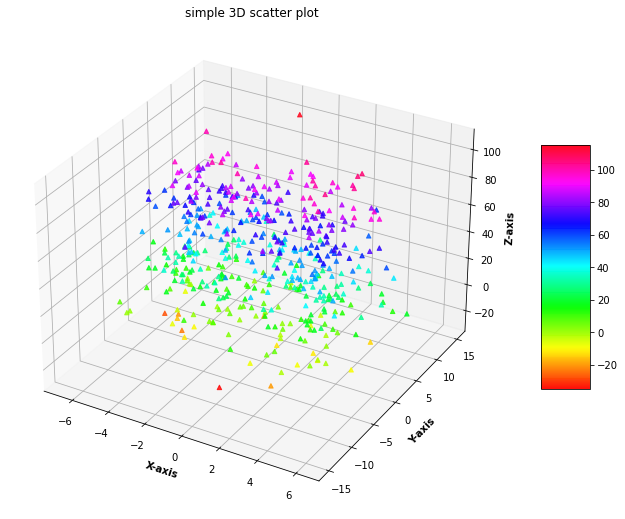

In [17]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
z = 4 * np.tan(np.random.randint(10, size =(500))) + np.random.randint(100, size =(500))
x = 4 * np.cos(z) + np.random.normal(size = 500)
y = 4 * np.sin(z) + 4 * np.random.normal(size = 500)
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z), 
                    cmap = my_cmap, 
                    marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

## 6. Určení segmentů

In [18]:
df['Segment'] = 'LOW_VALUE'
df.loc[df['OVERALL_SCORE']>1,'Segment'] = 'WITH_POTENTIAL'
df.loc[df['OVERALL_SCORE']>6,'Segment'] = 'FREQUENT_CUSTOMER'
df.loc[df['OVERALL_SCORE']>7,'Segment'] = 'PREMIUM_CLIENTS'
df.loc[df['OVERALL_SCORE']>13,'Segment'] = 'TOP_CLIENTS'

In [19]:
vystup=df.loc[:,['ID_CLIENT','RECENCY', 'FREQUENCY', 'MONETARY_VALUE','RECENCY_DAYS','OVERALL_SCORE']]
print(vystup.head())

   ID_CLIENT    RECENCY  FREQUENCY  MONETARY_VALUE  RECENCY_DAYS  \
0      72327 2019-05-25          2            2000           551   
1      72468 2019-04-13          8           -2134           593   
2      72619 2019-06-08         10           16000           537   
3      72358 2019-07-07          8            8000           508   
4      72408 2019-04-24          9           15000           582   

   OVERALL_SCORE  
0              6  
1              6  
2              6  
3              6  
4              6  


In [20]:
df.to_csv('RFM_1.csv', index=False, encoding='utf8')

In [21]:
outlier = df